In [1]:
pip install tensorflow numpy pandas matplotlib scikit-learn


**Importing required Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from keras.optimizers import Adam


Importing the example customers data set

In [3]:
df = pd.read_csv("/content/sales_data_sample.csv", encoding='ISO-8859-1')
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [4]:
df.columns

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')

**Data Preparation**


In [5]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Select the features you want to use
features = ['CUSTOMERNAME', 'COUNTRY', 'DEALSIZE']
data = df[features]

# Encode categorical features to numerical values
label_encoders = {}
for col in ['CUSTOMERNAME', 'COUNTRY', 'DEALSIZE']:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

# Normalize data to range [0, 1] for stable GAN training
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into training and test sets
train_data, test_data = train_test_split(data_scaled, test_size=0.2, random_state=42)

# Shape of the input data
input_dim = train_data.shape[1]

print(f"Input dimension: {input_dim}")


Input dimension: 3


<ipython-input-5-6399ae3fa8e7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = label_encoders[col].fit_transform(data[col])
<ipython-input-5-6399ae3fa8e7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = label_encoders[col].fit_transform(data[col])
<ipython-input-5-6399ae3fa8e7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [6]:
# GAN Model Definition
def build_generator(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(input_dim, activation='tanh'))  # Output matches input shape
    return model

In [7]:
def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (real/fake)
    return model


In [8]:
# Rebuild and recompile the models
def compile_gan(generator, discriminator):
    # Recompile the models with new optimizers if needed
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # Create GAN (stack generator and discriminator)
    discriminator.trainable = False  # Ensure the discriminator is not updated during GAN training
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)

    return gan

In [9]:
# Build the generator and discriminator
generator = build_generator(input_dim)
discriminator = build_discriminator(input_dim)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Recompile the GAN before training
gan = compile_gan(generator, discriminator)

In [11]:
def train_gan(generator, discriminator, gan, train_data, epochs=1000, batch_size=32, sample_interval=1000):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    generator_losses = []
    discriminator_losses = []

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, train_data.shape[0], batch_size)
        real_samples = train_data[idx]

        noise = np.random.normal(0, 1, (batch_size, input_dim))
        generated_samples = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_samples, valid)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        g_loss = gan.train_on_batch(noise, valid)

        # Save the loss to plot later
        discriminator_losses.append(d_loss[0])
        generator_losses.append(g_loss)

        if epoch % sample_interval == 0:
            print(f"Epoch {epoch} - D loss: {d_loss[0]}, G loss: {g_loss}")

    return generator_losses, discriminator_losses


In [12]:
generator_losses, discriminator_losses = train_gan(generator, discriminator, gan, train_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 - D loss: 0.6809393167495728, G loss: [array(0.6853663, dtype=float32), array(0.6853663, dtype=float32), array(0.6853663, dtype=float32), array(0.5625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

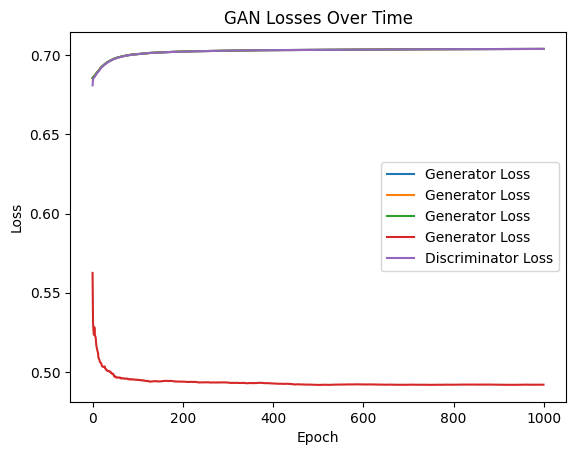

In [13]:
plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.title("GAN Losses Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
Generated Samples:
   CUSTOMERNAME    COUNTRY  DEALSIZE
0    -37.887680  18.000000  1.999782
1    -35.529289  17.999968  1.998553
2    -34.550278  17.999937  1.999908
3    -37.587242  18.000000  1.999875
4    -33.733433  18.000000  1.999804
5    -31.653149  18.000000  1.999614
6    -22.298239  18.000000  1.999199
7    -47.787273  18.000000  1.999879
8     90.999275 -18.000000  1.999846
9     90.949715 -18.000000  1.999734


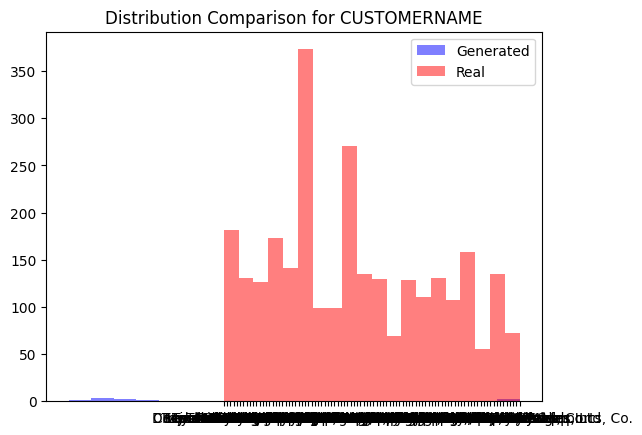

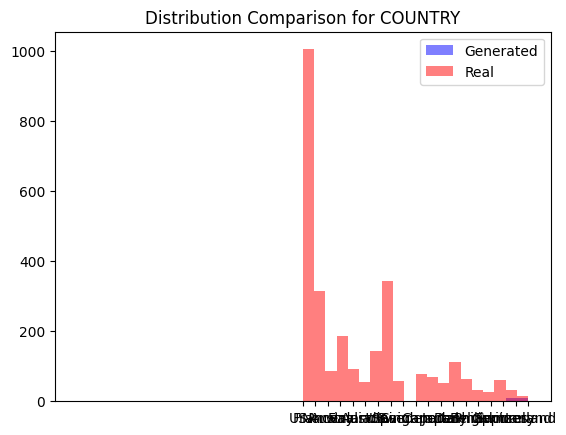

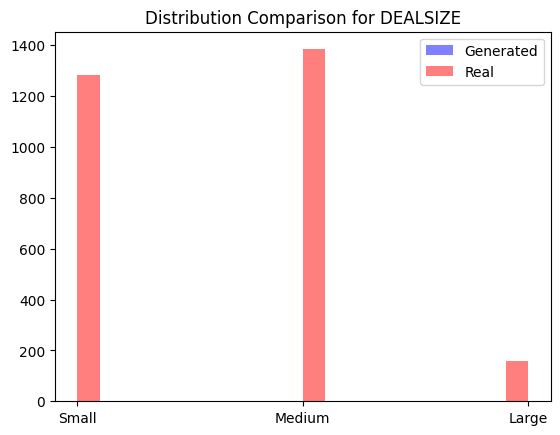

In [14]:
def visualize_generated_samples(generator, scaler, n_samples=10):
    noise = np.random.normal(0, 1, (n_samples, input_dim))
    generated_samples = generator.predict(noise)

    # Inverse transform the data back to original scale
    generated_samples_original = scaler.inverse_transform(generated_samples)

    # Convert back to DataFrame for easier comparison with real data
    generated_df = pd.DataFrame(generated_samples_original, columns=features)

    print("Generated Samples:")
    print(generated_df.head(n_samples))

    # Compare Distributions
    for col in features:
        plt.hist(generated_df[col], bins=20, alpha=0.5, label='Generated', color='blue')
        plt.hist(df[col], bins=20, alpha=0.5, label='Real', color='red')
        plt.title(f"Distribution Comparison for {col}")
        plt.legend()
        plt.show()

# Visualize generated samples
visualize_generated_samples(generator, scaler)

TypeError: 'Sequential' object is not subscriptable

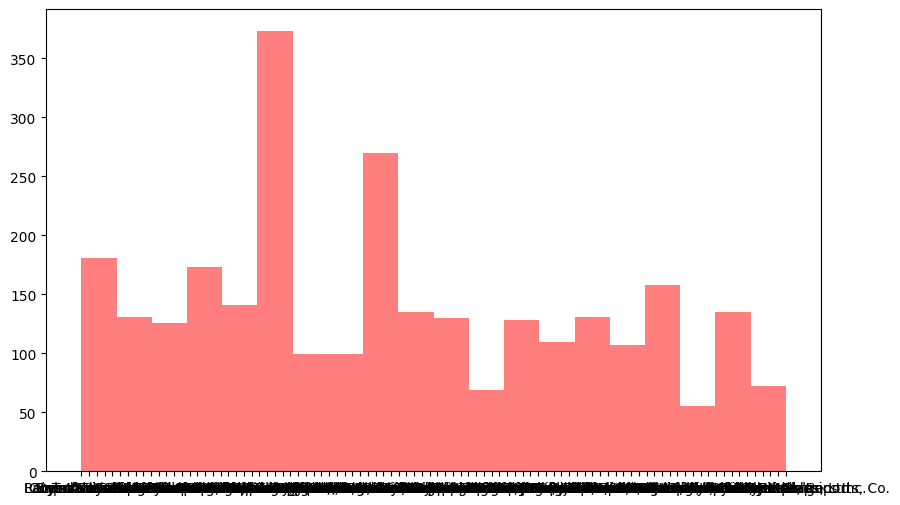

In [16]:
import matplotlib.pyplot as plt

# Assuming you have your real data in 'df' and generated samples in 'generated_df'
def compare_distributions(real_data, generated_data, features):
    for col in features:
        plt.figure(figsize=(10, 6))

        # Plot histograms
        plt.hist(real_data[col], bins=20, alpha=0.5, label='Real Data', color='red')
        plt.hist(generated_data[col], bins=20, alpha=0.5, label='Generated Data', color='blue')

        # Add titles and labels
        plt.title(f"Distribution Comparison for {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)

        # Show plot
        plt.show()

# Compare real data with generated data
compare_distributions(df[features], generator, features)
